<a href="https://colab.research.google.com/github/IvanKatorgin/Recommender-systems/blob/main/%D0%A0%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D1%8B_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Рекомендательные системы". Домашнее задание 2. Коллаборативная фильтрация. Каторгин И.П.

Описание задания

Пакет SURPRISE:
- используйте данные MovieLens 1M,
- можно использовать любые модели из пакета,
- получите RMSE на тестовом сете 0,87 и ниже.

Комментарий преподавателя:

В домашнем задании на датасет 1М может не хватить RAM. Можно сделать на 100K. Качество RMSE предлагаю считать на основе Cross-validation (5 фолдов), а не на отложенном датасете.

In [1]:
# установим пакет Surprise
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357277 sha256=5e1c54debdef51f83b393064d79d9e03f8b76cdb79c038d9513ebf51aebff84a
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [2]:
# импортируем библиотеки
import pandas as pd, numpy as np
from tqdm import tqdm_notebook
from scipy.spatial.distance import cityblock, cosine, euclidean, hamming, jaccard
from surprise import KNNWithMeans, KNNBaseline, KNNBasic, Dataset, accuracy, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
import warnings
warnings.filterwarnings("ignore")

Поскольку в домашнем задании 1, при работе с основным датасетом (ml-latest.zip (size: 335 MB)) каждый раз при попытке добавления таблицы с тегами к таблице с фильмами и рейтингами сеанс прерывался и выдавалось сообщение “Сеанс прекращен, так как объем ОЗУ полностью исчерпан” и было принято решение домашнее задание выполнять на усеченной выборке из файла ml-latest-small.zip (size: 1 MB), то в домашнем задании 2 также будем использовать усеченную выборку ml-latest-small.zip (size: 1 MB)

In [3]:
# загрузим датасет MovieLens с сайта https://grouplens.org/datasets/movielens/
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2024-12-01 15:15:46--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2024-12-01 15:15:47 (6.69 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [4]:
# прочитаем файлы
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
links = pd.read_csv('ml-latest-small/links.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

In [5]:
# объединим таблицы ratings и movies
movies_with_ratings = pd.merge(ratings, movies, on='movieId').reset_index(drop=True)
movies_with_ratings.dropna(inplace=True)
movies_with_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [6]:
# посмотрим на размер датасета (количество уникальных пользователей и фильмов)
print(f"фильмы: {len(movies_with_ratings['movieId'].unique())}.")
print(f"пользователи: {len(movies_with_ratings['userId'].unique())}.")

фильмы: 9724.
пользователи: 610.


In [7]:
# датасет для Surprise
dataset = pd.DataFrame({
    'uid': movies_with_ratings.userId,
    'iid': movies_with_ratings.title,
    'rating': movies_with_ratings.rating
})

In [8]:
dataset.head()

,uid,iid,rating
0,1,Toy Story (1995),4.0
1,1,Grumpier Old Men (1995),4.0
2,1,Heat (1995),4.0
3,1,Seven (a.k.a. Se7en) (1995),5.0
4,1,"Usual Suspects, The (1995)",5.0


In [9]:
# минимальное значение рейтинга
ratings.rating.min()

0.5

In [10]:
# максимальное значение рейтинга
ratings.rating.max()

5.0

In [11]:
# данные для создания модели
reader = Reader(rating_scale=(dataset['rating'].min(), dataset['rating'].max()))
data = Dataset.load_from_df(dataset, reader)

In [12]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=1)

In [13]:
dataset['uid'].nunique(), dataset['iid'].nunique()

(610, 9719)

In [14]:
# создадим таблицу для записи результатов
# Метрики качества: | модель | подход | RMSE |
final = pd.DataFrame(columns=['модель','подход', 'RMSE'])
final

,модель,подход,RMSE


## Модель KNNWithMeans на основе кроссвалидации

user_based

In [15]:
algo = KNNWithMeans(k=40, sim_options={
    'name': 'pearson_baseline',
    'user_based': True
})
res = cross_validate(algo, data, measures=['RMSE'], cv=50)

print(f"RMSE: {np.mean(res['test_rmse'])}.")

final = pd.concat([final, pd.DataFrame([{'модель': 'KNNWithMeans','подход': "user_based", 'RMSE': np.mean(res['test_rmse'])}])])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [16]:
algo.fit(trainset)
test_pred = algo.test(testset)
accuracy.rmse(test_pred, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9005


0.9004886374988647

In [17]:
test_pred[:3]

[Prediction(uid=469, iid='Broadcast News (1987)', r_ui=4.0, est=3.658227906795145, details={'actual_k': 14, 'was_impossible': False}),
 Prediction(uid=187, iid='Inland Empire (2006)', r_ui=4.0, est=3.532040903347028, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid=399, iid='Terminator 2: Judgment Day (1991)', r_ui=2.5, est=4.487133875725281, details={'actual_k': 40, 'was_impossible': False})]

In [18]:
algo.predict(uid=2, iid='Fight Club (1999)')

Prediction(uid=2, iid='Fight Club (1999)', r_ui=None, est=4.604828436125544, details={'actual_k': 40, 'was_impossible': False})

item_based

In [19]:
algo = KNNWithMeans(k=40, sim_options={
    'name': 'pearson_baseline',
    'user_based': False
})
result = cross_validate(algo, data, measures=['RMSE'], cv=50)

print(f"RMSE: {np.mean(result['test_rmse'])}.")

final = pd.concat([final, pd.DataFrame([{'модель': 'KNNWithMeans','подход': "item_based", 'RMSE': np.mean(res['test_rmse'])}])])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

In [20]:
algo.fit(trainset)
test_pred = algo.test(testset)
accuracy.rmse(test_pred, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8821


0.8821457738147519

In [21]:
new_pred = algo.predict(uid=2, iid='Fight Club (1999)')
new_pred

Prediction(uid=2, iid='Fight Club (1999)', r_ui=None, est=4.162080258212882, details={'actual_k': 18, 'was_impossible': False})

In [22]:
new_pred = algo.predict(uid=20000, iid='Fight Club (1999)')
new_pred

Prediction(uid=20000, iid='Fight Club (1999)', r_ui=None, est=3.5038119204641247, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [23]:
new_pred = algo.predict(uid=2, iid='unkown')
new_pred

Prediction(uid=2, iid='unkown', r_ui=None, est=3.5038119204641247, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [24]:
trainset.global_mean

3.5038119204641247

Результаты модели KNNWithMeans на основе кроссвалидации:
- user_based RMSE: 0.8812
- item_based RMSE: 0.8672

## Модель KNNBaseline на основе кроссвалидации

user_based

In [25]:
algo = KNNBaseline(k=40, sim_options={
    'name': 'pearson_baseline',
    'user_based': True
})
res = cross_validate(algo, data, measures=['RMSE'], cv=50)

print(f"RMSE: {np.mean(res['test_rmse'])}.")

final = pd.concat([final, pd.DataFrame([{'модель': 'KNNBaseline','подход': "user_based", 'RMSE': np.mean(res['test_rmse'])}])])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

item_based

In [26]:
algo = KNNBaseline(k=40, sim_options={
    'name': 'pearson_baseline',
    'user_based': False
})
res = cross_validate(algo, data, measures=['RMSE'], cv=50)

print(f"RMSE: {np.mean(res['test_rmse'])}.")

final = pd.concat([final, pd.DataFrame([{'модель': 'KNNBaseline','подход': "item_based", 'RMSE': np.mean(res['test_rmse'])}])])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Результаты модели KNNBaseline на основе кроссвалидации:
- user_based RMSE: 0.8629
- item_based RMSE: 0.8414

## Модель SVD на основе кроссвалидации

In [27]:
#  модель SVD
algo = SVD(n_factors=40, n_epochs=30)
res = cross_validate(algo, data, measures=['RMSE'], cv=50)
print(f"RMSE: {np.mean(res['test_rmse'])}.")
final = pd.concat([final, pd.DataFrame([{'модель': 'SVD','подход': "-", 'RMSE': np.mean(res['test_rmse'])}])])

RMSE: 0.861264447363395.


RMSE модели SVD на основе кроссвалидации: 0.8612

## Выводы

In [28]:
final.sort_values(by = 'RMSE', ascending=True, inplace=True)
final

,модель,подход,RMSE
0,KNNBaseline,item_based,0.841463
0,SVD,-,0.861264
0,KNNBaseline,user_based,0.862966
0,KNNWithMeans,user_based,0.881267
0,KNNWithMeans,item_based,0.881267


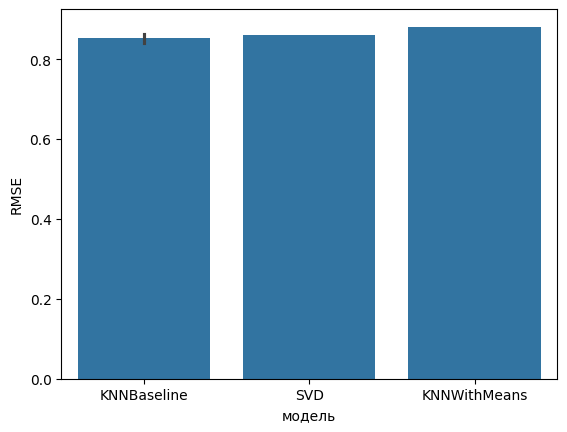

In [29]:
# посмотрим на результаты графически
sns.barplot(x='модель', y='RMSE', data=final)
plt.show()

В работе рассмотрено 5 различных моделей на основе кроссвалидации:
- KNNWithMeans user_based
- KNNWithMeans item_based
- KNNBaseline user_based
- KNNBaseline item_based
- SVD
Лучшая модель - KNNBaseline на основе кроссвалидации (item_based). RMSE - 0.84146